<a href="https://colab.research.google.com/github/Mekaela/isa_machine_learning/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [4]:
def getData():
    url = 'https://raw.githubusercontent.com/isa-ulisboa/greends-pml/main/data/aquifer_time_series.csv'
    try:
        df = pd.read_csv(url)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

I will call each method in between, but these will all be called in the main function at the end

In [9]:
df = getData()
df.head(5)

,date,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m
0,14/03/2006,NaN,-22.18,NaN,NaN,NaN
1,15/03/2006,NaN,-22.14,NaN,NaN,NaN
2,16/03/2006,NaN,-22.04,NaN,NaN,NaN
3,17/03/2006,NaN,-22.04,NaN,NaN,NaN
4,18/03/2006,NaN,-22.04,NaN,NaN,NaN


Plotting all variables to get a sense of the data. I will not call this in the main function, but will call it multiple times when preprocessing the data to get a sense of what needs to be done.

In [31]:
def plot_all_variables(df):
    # Convert the 'Date' column to datetime objects
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)

    # Iterate through each column (excluding the date column) and plot it
    for column in df.columns:
        if column != 'date':
          plt.figure(figsize=(8, 4))  # Adjust figure size as needed
          plt.plot(df['date'], df[column])
          plt.xlabel('Date')
          plt.ylabel(column)
          plt.title(f'Time Series Plot of {column}')

          # Format the x-axis to display dates nicely
          years = mdates.YearLocator()
          years_fmt = mdates.DateFormatter('%Y')
          plt.gca().xaxis.set_major_locator(years)
          plt.gca().xaxis.set_major_formatter(years_fmt)

          plt.grid(True)
          plt.show()

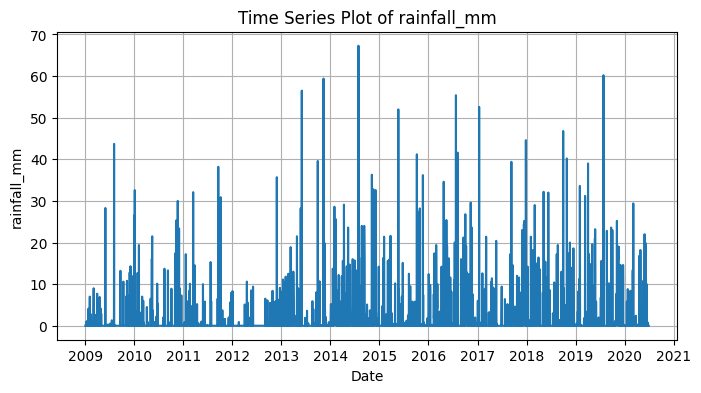

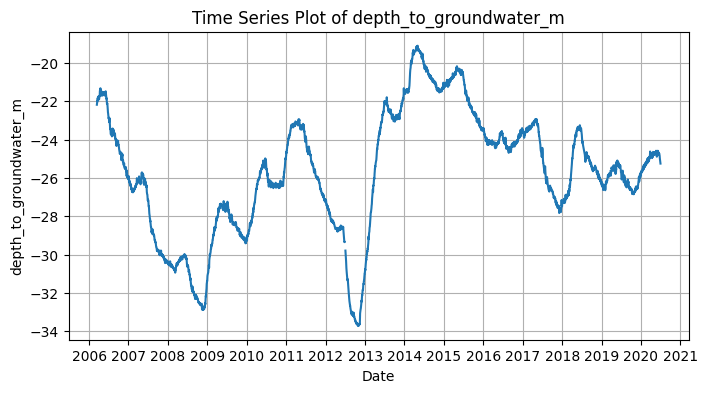

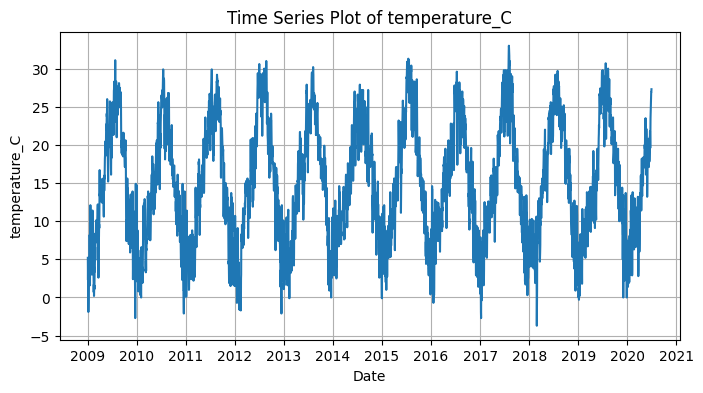

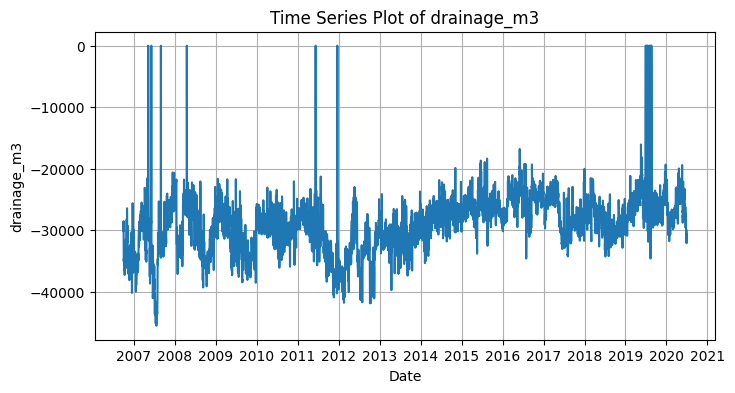

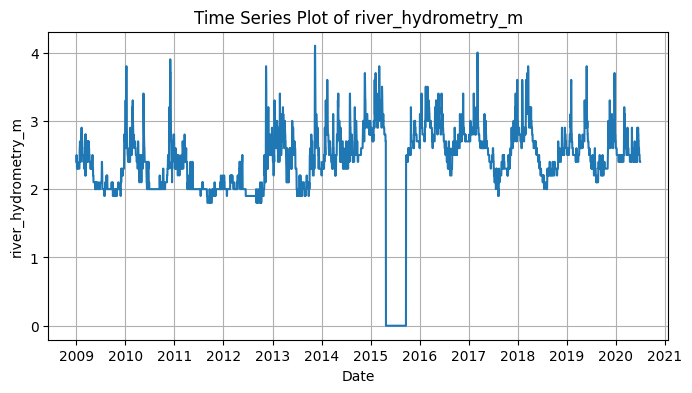

In [32]:
# Call the functions
df = getData()
plot_all_variables(df)

This shows that some data transformation needs to happen. depth_to_groundwater_m, and drainage_m3 can be corrected by finding the mean of the closest values either side of the zeroes. hydrometry_m could be solved using a forecasting technique, but for simplicity and time constraints, I will also use the mean of the values either side of it.

I won't call plot_all_variables() in the final main function, so I will need to convert to datetime again in preprocessing:

In [33]:
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    for col in ['depth_to_groundwater_m', 'drainage_m3', 'river_hydrometry_m']:
        # Find indices of zero values
        zero_indices = df[df[col] == 0].index

        for index in zero_indices:
            # Find closest non-zero values before and after
            left_idx = index - 1
            right_idx = index + 1
            while left_idx >= 0 and df.loc[left_idx, col] == 0:
                left_idx -= 1
            while right_idx < len(df) and df.loc[right_idx, col] == 0:
                right_idx += 1

            # Calculate the mean of the closest non-zero values
            if left_idx >= 0 and right_idx < len(df):
                mean_val = (df.loc[left_idx, col] + df.loc[right_idx, col]) / 2
                df.loc[index, col] = mean_val
            elif left_idx >= 0:
                df.loc[index, col] = df.loc[left_idx,col]
            elif right_idx < len(df):
                df.loc[index, col] = df.loc[right_idx, col]
    return df

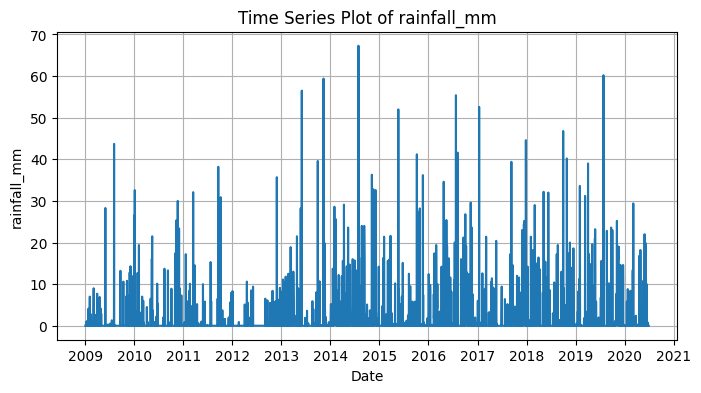

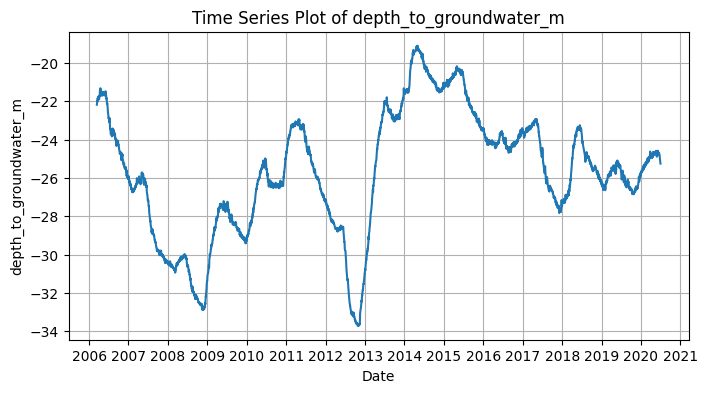

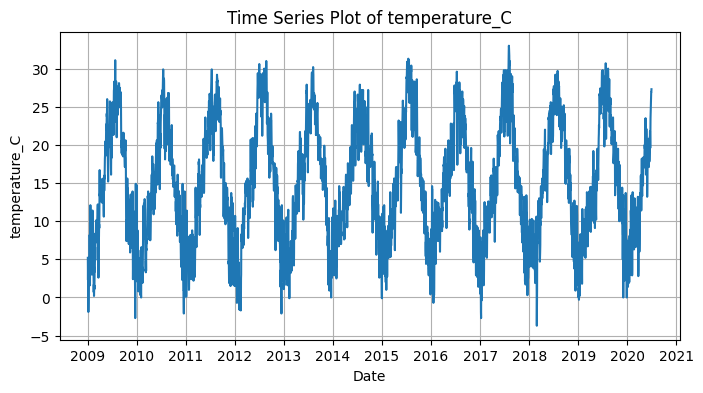

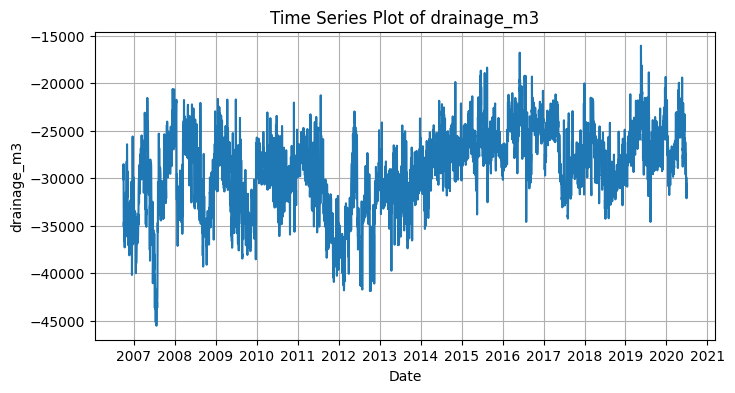

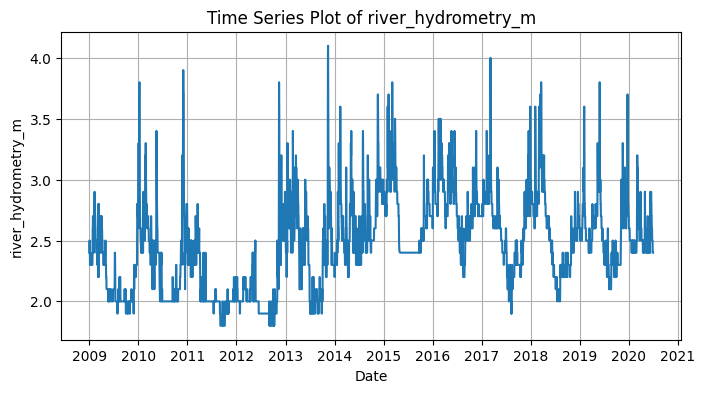

In [35]:
if df is not None:
    df = preprocess_data(df)
plot_all_variables(df)

As we can see, river_hydrometry still looks incorrect, but is better than zeroes. drainage looks how it should look, which makes sense given that there were not many zeroes in this data. depth_to_grounwater_m still looks like it has zeroes.

In [18]:
nan_values = df[df['depth_to_groundwater_m'].isna()]
nan_values


,date,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m
433,2007-05-21,NaN,NaN,NaN,-31250.880,NaN
645,2007-12-19,NaN,NaN,NaN,-25753.248,NaN
795,2008-05-17,NaN,NaN,NaN,-28870.560,NaN
796,2008-05-18,NaN,NaN,NaN,-25233.120,NaN
797,2008-05-19,NaN,NaN,NaN,-24730.272,NaN
798,2008-05-20,NaN,NaN,NaN,-24338.016,NaN
799,2008-05-21,NaN,NaN,NaN,-25265.952,NaN
800,2008-05-22,NaN,NaN,NaN,-25942.464,NaN
801,2008-05-23,NaN,NaN,NaN,-28456.704,NaN
802,2008-05-24,NaN,NaN,NaN,-27433.728,NaN


Need to change NaN's to closest values either side of NaN's

In [37]:
def fill_nan_depth_groundwater(df):
    """Fills NaN values in 'depth_to_groundwater_m' with the average of the closest non-NaN values."""

    col = 'depth_to_groundwater_m'
    nan_indices = df[df[col].isna()].index

    for index in nan_indices:
        left_idx = index - 1
        right_idx = index + 1

        while left_idx >= 0 and pd.isna(df.loc[left_idx, col]):
            left_idx -= 1
        while right_idx < len(df) and pd.isna(df.loc[right_idx, col]):
            right_idx += 1

        if left_idx >= 0 and right_idx < len(df):
            mean_val = (df.loc[left_idx, col] + df.loc[right_idx, col]) / 2
            df.loc[index, col] = mean_val
        elif left_idx >= 0:
            df.loc[index, col] = df.loc[left_idx, col]
        elif right_idx < len(df):
            df.loc[index, col] = df.loc[right_idx, col]
    return df


scale and smooth data:

In [25]:
def scale_data(df):
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Select the columns to scale (exclude the 'date' column)
    columns_to_scale = [col for col in df.columns if col != 'date']

    # Fit and transform the selected columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df

In [15]:
    df = scale_data(df)
    print(df.head())

        date  rainfall_mm  depth_to_groundwater_m  temperature_C  drainage_m3  \
0 2006-03-14          NaN                0.789185            NaN          NaN   
1 2006-03-15          NaN                0.791923            NaN          NaN   
2 2006-03-16          NaN                0.798768            NaN          NaN   
3 2006-03-17          NaN                0.798768            NaN          NaN   
4 2006-03-18          NaN                0.798768            NaN          NaN   

   river_hydrometry_m  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  


In [28]:
def smooth_data(df):
    # Set the 'date' column as the index
    df = df.set_index('date')

    # Resample to monthly frequency, taking the mean of each month
    df_monthly = df.resample('ME').median()

    # Reset the index to make 'date' a column again
    df_monthly = df_monthly.reset_index()
    return df_monthly

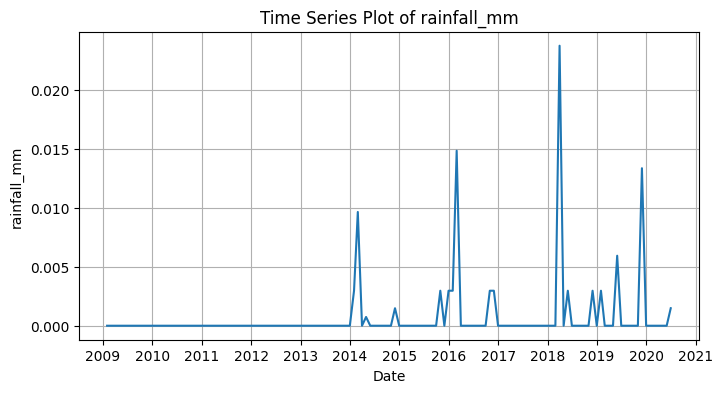

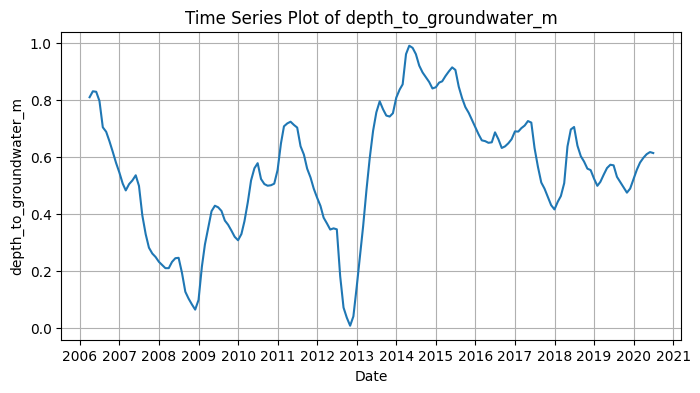

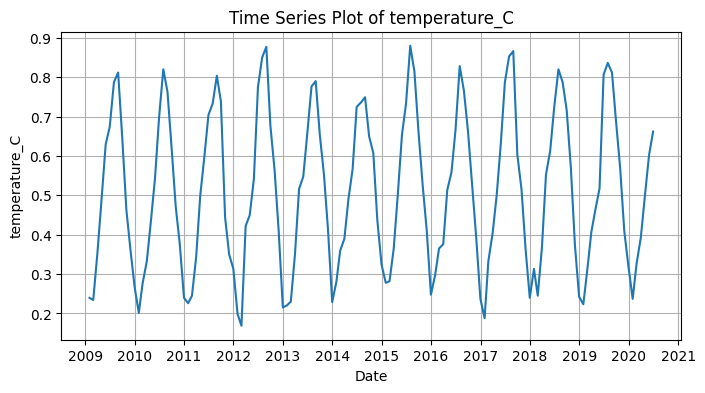

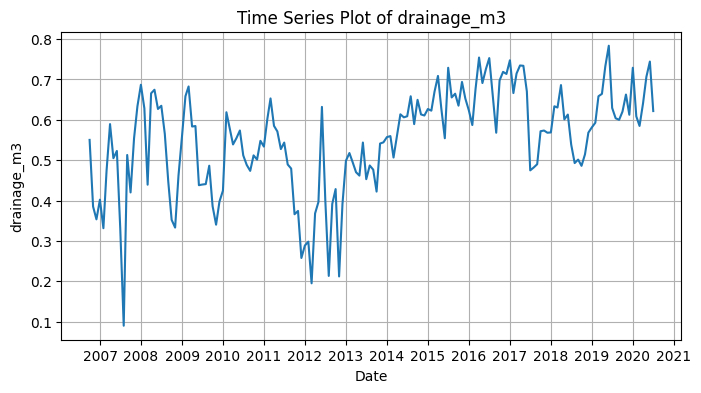

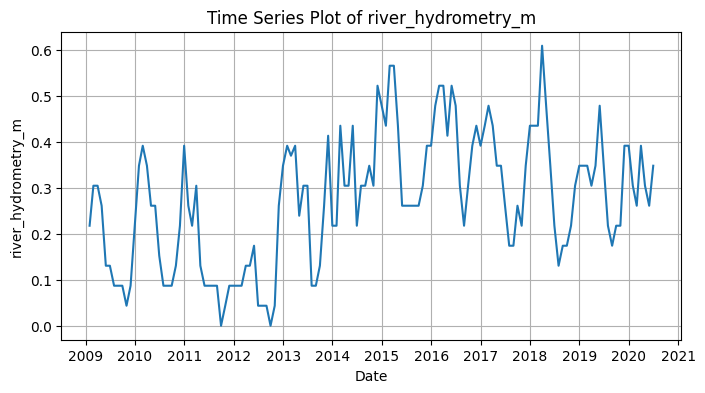

In [29]:
df_monthly = smooth_data(df)
plot_all_variables(df_monthly)

The median didn't work too well for rainfall, however trying mean looked pretty much the same. It makes sense when most months don't have a lot of rainy days, but maybe it would be more useful another way - such as total rainfall per month. For now, we'll stick with median.

In [48]:
df_monthly.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,172,2013-05-15 20:39:04.186046464,2006-03-31 00:00:00,2009-10-23 06:00:00,2013-05-15 12:00:00,2016-12-07 18:00:00,2020-06-30 00:00:00,NaN
rainfall_mm,138.0,0.000711,0.0,0.0,0.0,0.0,0.023774,0.002844
depth_to_groundwater_m,172.0,0.548756,0.007529,0.4141,0.558522,0.703799,0.989733,0.220815
temperature_C,138.0,0.509991,0.168937,0.345027,0.5,0.672343,0.880109,0.201775
drainage_m3,166.0,0.550582,0.090161,0.47998,0.568573,0.634508,0.783521,0.125824
river_hydrometry_m,138.0,0.273629,0.0,0.173913,0.26087,0.391304,0.608696,0.139847


In [8]:
def get_best_model(df_monthly):
    # Define features (X) and target (y)
    X = df_monthly.drop(['depth_to_groundwater_m', 'date'], axis=1)
    y = df_monthly['depth_to_groundwater_m']


    # Define the parameter grid for RandomForestRegressor
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize RandomForestRegressor
    rf = RandomForestRegressor(random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)

    # Print the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best score (negative MSE):", grid_search.best_score_)

    # Get the best model
    best_rf_model = grid_search.best_estimator_
    return best_rf_model


In [18]:
best_model = get_best_model(df_monthly)

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best score (negative MSE): -0.05202861350231684


In [1]:
# prompt: for each month use the last 12 months data to predict it's value, using the fitted model

def predict_future_months(df_monthly, best_rf_model):
    # Make predictions for each month using the last 12 months of data
    predictions = []
    for i in range(12, len(df_monthly)):
        # Use the last 12 months of data to predict the current month
        X_current = df_monthly.drop(['depth_to_groundwater_m', 'date'], axis=1).iloc[i-12:i]
        y_pred = best_rf_model.predict(X_current)
        predictions.append(y_pred[-1])  # Append the prediction for the last month

    return predictions


In [19]:
predict_future_months(df_monthly, best_model)

[np.float64(0.40167195940039896),
 np.float64(0.33843818091559386),
 np.float64(0.42623763522582836),
 np.float64(0.4537291210576633),
 np.float64(0.3856861634828783),
 np.float64(0.38427188428728487),
 np.float64(0.42672076810937193),
 np.float64(0.2917971878110483),
 np.float64(0.3715135476167305),
 np.float64(0.24960141184011841),
 np.float64(0.312533289035856),
 np.float64(0.24942222928413912),
 np.float64(0.2610835967971492),
 np.float64(0.27093526716268007),
 np.float64(0.30474664583648176),
 np.float64(0.25448879599752305),
 np.float64(0.2615280113642539),
 np.float64(0.3324389197007268),
 np.float64(0.26011165976771733),
 np.float64(0.3801293217201844),
 np.float64(0.35955695756825135),
 np.float64(0.2833113762046001),
 np.float64(0.3333705494824592),
 np.float64(0.44887684573102504),
 np.float64(0.49938053920083775),
 np.float64(0.5355036210462292),
 np.float64(0.5399093072111555),
 np.float64(0.42631266924952754),
 np.float64(0.4338687191392531),
 np.float64(0.404611672512596

In [21]:
def actual_vs_predicted_plot(df_monthly, predictions):
    # Extract actual values for the plotted predictions
    actual_values = df_monthly['depth_to_groundwater_m'].iloc[12:].values

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_monthly['date'].iloc[12:], actual_values, label='Actual', color = 'blue')
    plt.plot(df_monthly['date'].iloc[12:], predictions, label='Predicted', color = 'red')

    plt.xlabel('Date')
    plt.ylabel('Depth to Groundwater (m)')
    plt.title('Actual vs. Predicted Depth to Groundwater')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
predictions = predict_future_months(df_monthly, best_model)
actual_vs_predicted_plot(df_monthly, predictions)

That should cover everything except the main function. I found this assignment a bit confusing. At first I designed a project which the user would specify the date and then it would predict for that value, but then I would only have one predicted v actual value to graph, so I changed it to predict every month value after the first 12 months.
I also think there's some more work I could do with preprocessing, as the preprocessing for removing NaN's was done over all values of depth_to_groundwater, when it should've only been done for the values in 2012. As I mentioned earlier too, a forecasting process would've been better for river_hydrometry_m.


Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best score (negative MSE): -0.052100592981144465


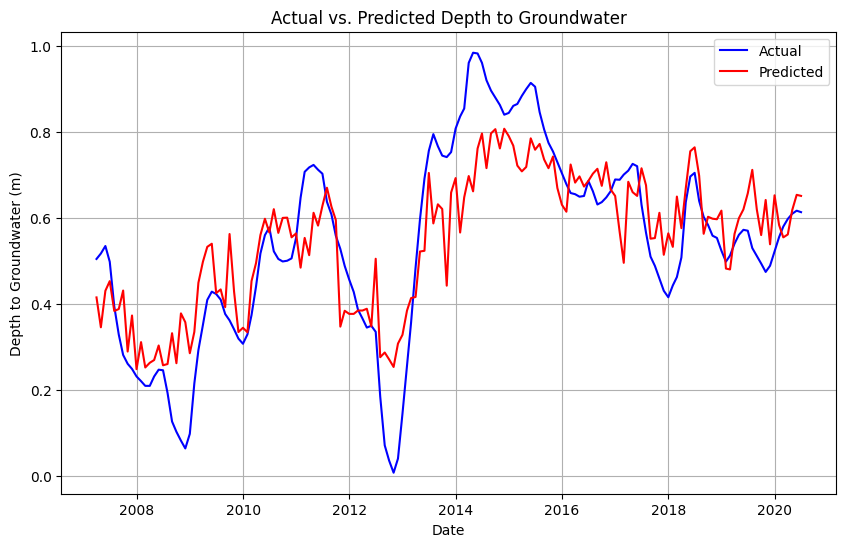

In [38]:
def main():
    # 1. Get data
    df = getData()

    # 2. Preprocess data
    if df is not None:
        df = preprocess_data(df)
        df = fill_nan_depth_groundwater(df)
        df = scale_data(df)
        df_monthly = smooth_data(df)
    else:
        print("DataFrame is empty or could not be loaded.")
        return None

    # 3. Get best model
    if df_monthly is not None:
        best_model = get_best_model(df_monthly)
    else:
        print("DataFrame is empty or could not be loaded.")
        return None

    # 4. Predict future months
    predictions = predict_future_months(df_monthly, best_model)

    # 5. Plot actual vs predicted
    actual_vs_predicted_plot(df_monthly, predictions)

if __name__ == "__main__":
    main()


I am quite surprised that the forecast 12 months after the 2015 gap in river hydrometry is quite good. An improvement could be to more accurately process the rainfall so there aren't so many zero days.